In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [326]:
class GraphNet:
    # Make an empty graph on n nodes with linear activation
    def __init__(self, n):
        self.size = n
        self.adj = np.zeros((n, n))
        self.weights = np.zeros((n, n))
        self.act = ['linear' for i in range(self.size)]
        self.input_nodes = [0] # Default
        self.output_nodes = [n-1] # Default
        self.tempstates = [[0 for i in range(self.size)]]
        self.states = [[0 for i in range(self.size)]]
        self.mode = 'overwrite'
        self.time = 0
    
    # Sets the mode for the step method
    # Options: overwrite, add
    def mode(self, m):
        self.mode = m
    
    # Connect an edge from node i to node j
    def connect(self, i, j):
        self.adj[j,i] = 1
    
    # Connect a list of nodes in a sequential loop
    def connect_loop(self, v):
        for i in range(len(v)):
            self.adj[v[(i+1)%len(v)], v[i]] = 1
    
    # Connect in a clique, other than self-connections
    def connect_complete(self, v):
        for i in range(len(v)):
            for j in range(len(v)):
                if i == j:
                    continue
                self.adj[v[j], v[i]] = 1
    
    # Change activation on node i
    # Options: linear, relu, sigmoid/logistic, tanh
    def activation(self, i, f):
        self.act[i] = f
    
    # Change activations on a list of nodes
    def activations(self, v, f):
        for i in range(len(v)):
            self.act[v[i]] = f
    
    # Get the list of edge weights that are inputs to node i
    def inputs(self, i):
        ins = []
        for k in range(self.size):
            if self.adj[i,k] != 0:
                ins.append(k)
        return ins
    
    # Get the list of edge weights that are outputs from node i
    def outputs(self, i):
        outs = []
        for k in range(self.size):
            if self.adj[k,i] != 0:
                outs.append(k)
        return outs
    
    # Reset weights
    def reset_weights(self):
        self.weights = np.copy(self.adj)
        self.reset_state() # No reason to save the state if the weights were reset.
    
    # Initialize random edge weights, assuming edge weights are all 0 or 1
    def init_random(self):
        self.weights = np.random.normal(size=(self.size, self.size))*self.adj
    
    # Normalize columns to satisfy Markov state transition rules
    def init_markov(self):
        self.init_random()
        for i in range(self.size):
            colsum = sum(self.weights[:,i])
            if colsum != 0:
                for j in range(self.size):
                    self.weights[j,i] /= colsum
    
    # Make the vector of indices be the input nodes
    def define_input(self, v):
        self.input_nodes = v
    
    # Make the vector of indices be the output nodes
    def define_output(self, v):
        self.output_nodes = v
    
    # Reset state
    def reset_state(self):
        self.states = [[0 for i in range(self.size)]]
        self.tempstates = [[0 for i in range(self.size)]]
    
    # Runs one time step of the network, with the given input values, and returns the current output values
    def step(self, input_vals):
        self.time += 1
        # tempstate = [self.states[-1][i] for i in range(self.size)]
        # Edit the inputs of the last state. This will make things consistent, so each step is a single state
        if self.mode == 'overwrite':
            for i in range(len(self.input_nodes)):
                self.states[-1][self.input_nodes[i]] = input_vals[i]
        if self.mode == 'add':
            for i in range(len(self.input_nodes)):
                self.states[-1][self.input_nodes[i]] += input_vals[i]
        
        # Bias neurons need to be activated before the step
        for i in range(self.size):
            if self.act[i] == 'bias':
                self.states[-1][i] = 1
        
        # Weighted sum of inputs
        tempstate = np.dot(self.weights, self.states[-1])
        # Apply activation functions
        state = [tempstate[i] for i in range(self.size)]
        
        for i in range(self.size):
            #if self.act[i] == 'linear':
            #    do nothing
            if self.act[i] == 'relu':
                state[i] = state[i] if state[i] > 0 else 0
            if self.act[i] == 'sigmoid' or self.act[i] == 'logistic':
                state[i] = 1.0/(1.0+math.exp(-state[i]))
            if self.act[i] == 'tanh':
                state[i] = (math.exp(2*state[i]) - 1)/(math.exp(2*state[i]) + 1)
        
        output_vals = [state[self.output_nodes[i]] for i in range(len(self.output_nodes))]
        self.tempstates.append(tempstate)
        self.states.append(state)
        return output_vals
    
    # Runs several time steps of the network, with the given vector of input value vectors at each time step, 
    # and returns a vector of output values
    def steps(self, input_vals_v, n=0):
        output_vals_v = []
        empty_input = [0 for i in range(len(self.input_nodes))]
        for t in range(max(n, len(input_vals_v))):
            input_vals = empty_input
            if t < len(input_vals_v):
                input_vals = input_vals_v[t]
            output_vals_v.append(self.step(input_vals))
        return output_vals_v
    
    # Run n steps on a input only at initial step
    def stepn(self, input_vals_0, n=1, reset=True):
        if reset:
            self.reset_state()
        output_vals_v = []
        empty_input = [0 for i in range(len(self.input_nodes))]
        for t in range(n):
            input_vals = empty_input
            if t == 0:
                input_vals = input_vals_0
            output_vals_v.append(self.step(input_vals))
        return output_vals_v
    
    # Run as many steps as necessary until you get a nonzero output
    def stepv(self, input_vals_0, reset=True, max_step=100, verbose=True):
        if reset:
            self.reset_state()
        output_vals = [0 for i in range(len(self.output_nodes))]
        empty_input = [0 for i in range(len(self.input_nodes))]
        t = 0
        while t < max_step and np.count_nonzero(output_vals) == 0:
            input_vals = empty_input
            if t == 0:
                input_vals = input_vals_0
            output_vals = self.step(input_vals)
            t += 1
        if t == max_step:
            print("Max step reached!")
        if verbose:
            print(t)
        return output_vals
    
    # Waits until the first nonzero output value and uses that as the real output
    def error_first(self, train_vals, label_vals, max_step=100):
        self.reset_state()
        output_vals = [0 for i in range(len(self.output_nodes))]
        empty_input = [0 for i in range(len(self.input_nodes))]
        t = 0
        while t < max_step and np.count_nonzero(output_vals) == 0:
            input_vals = empty_input
            if t == 0:
                input_vals = train_vals
            output_vals = self.step(input_vals)
            t += 1
        if t == max_step:
            print("Max step reached!")
        err_v = np.subtract(output_vals, label_vals)
        return err_v
    
    # Waits a fixed delay
    def error_delay(self, train_vals, label_vals, delay, reset=True, max_step=100):
        if reset:
            self.reset_state()
        output_vals = [0 for i in range(len(self.output_nodes))]
        empty_input = [0 for i in range(len(self.input_nodes))]
        t = 0
        while t < delay:
            input_vals = empty_input
            if t == 0:
                input_vals = train_vals
            output_vals = self.step(input_vals)
            t += 1
        err_v = np.subtract(output_vals, label_vals)
        return err_v
    
    def error_sequence(self, train_seq, label_seq, delay, reset=True):
        if reset:
            self.reset_state()
        output_seq = []
        empty_input = [0 for i in range(len(self.input_nodes))]
        t = 0
        while t < delay+len(label_seq):
            input_vals = empty_input
            if t < len(train_seq):
                input_vals = train_seq[t]
            if t < delay:
                self.step(input_vals)
            else:
                output_seq.append(self.step(input_vals))
            t += 1
        #print(output_seq)
        #print(label_seq)
        err_v = np.subtract(np.asarray(output_seq), np.asarray(label_seq))
        #print('Err_v: '+str(err_v))
        return err_v
    
    # Mean square error of training batch. train_x and train_y are batches of training data
    # If delay = 0, first nonzero output will be used, otherwise there will be a fixed delay before the output is sampled
    def mse_batch(self, train_x, train_y, delay=0, reset=True, max_step=100):
        data_type = 'fixed'
        if len(np.asarray(train_x).shape) == 3:
            data_type = 'sequence'
        mse = 0
        for k in range(len(train_x)):
            if data_type == 'fixed':
                if delay == 0:
                    mse += sum(self.error_first(train_x[k], train_y[k], max_step)**2)
                else:
                    mse += sum(self.error_delay(train_x[k], train_y[k], delay, reset, max_step)**2)
            elif data_type == 'sequence':
                val = self.error_sequence(train_x[k], train_y[k], delay, reset)
                #print('Err: '+str(val))
                mse += sum(val**2)
        mse /= 2*len(train_x) # Factor of 1/2 for the coefficient of 2 on the derivative to cancel, as usual...
        return mse
    
    def backprop(self, train_vals, label_vals, delay=1, verbose=False):
        downscaling = 0.9
        dw = np.zeros((self.size, self.size))
        # E = 1/2 (observed - expected)**2
        err_v = [[0 for i in range(len(self.output_nodes))]] #Unused...
        if len(np.asarray(label_vals).shape) == 1:
            err_v = [self.error_delay(train_vals, label_vals, delay)]
        if len(np.asarray(label_vals).shape) == 2:
            err_v = self.error_sequence(train_vals, label_vals, delay=delay)
        for dt in range(len(err_v)):
            nodes_i = [self.output_nodes[i] for i in range(len(self.output_nodes))]
            nodes_d = [err_v[i] for i in range(len(self.output_nodes))]
            newnodes_i = []
            newnodes_d = []
            # dE/dw = (observed - expected) * d(observed)/dw
            for k in range(1, len(self.states)-dt): # Or max step size, maybe? 
                for i in range(len(nodes_i)):
                    # node value = activation( weighted sum of input values )
                    # d node value / dw = activation'( weighted sum of input values ) * d (weighted sum of input values) / dw
                    node_val = self.states[len(self.states)-k-dt][nodes_i[i]]
                    node_sum = self.tempstates[len(self.states)-k-dt][nodes_i[i]]
                    act_deriv = 1
                    #if self.act[nodes_i[i]] == 'linear':
                    #    do nothing
                    if self.act[nodes_i[i]] == 'relu' and node_sum < 0:
                        act_deriv = 0
                    if self.act[nodes_i[i]] == 'sigmoid' or self.act[nodes_i[i]] == 'logistic':
                        act_deriv = node_val * (1 - node_val)
                    if self.act[nodes_i[i]] == 'tanh':
                        act_deriv = 4.0/(math.exp(node_sum)+math.exp(-node_sum))**2
                    in_nodes_i = self.inputs(nodes_i[i])
                    for j in range(len(in_nodes_i)):
                        # Self-weights are covered just fine when nodes_i[i] = in_nodes_i[j]
                        in_node_val = self.states[len(self.states)-(k+1)-dt][in_nodes_i[j]]
                        # d (weighted sum of input values) / dw = input value [...for w in these weights]
                        dweight = nodes_d[i] * act_deriv * in_node_val
                        # Add this to the total derivative with respect to this weight
                        dw[nodes_i[i], in_nodes_i[j]] += dweight * (downscaling ** dt) # downscale by a constant factor..?
                        if verbose:
                            print(dw)
                        # nodes_d stores the buildup of chained derivatives
                        weight = self.weights[nodes_i[i], in_nodes_i[j]]
                        # d (weighted sum of input values) / dw = ... * weight * d node value / dw
                        if in_nodes_i[j] in newnodes_i:
                            index = newnodes_i.index(in_nodes_i[j])
                            newnodes_d[index] += nodes_d[i] * act_deriv * weight
                        else:
                            newnodes_i.append(in_nodes_i[j])
                            newnodes_d.append( nodes_d[i] * act_deriv * weight )
                nodes_i = newnodes_i
                nodes_d = newnodes_d
                newnodes_i = []
                newnodes_d = []
        dw /= len(err_v)
        return dw
    
    # Uses the whole dataset as the batches
    def train(self, train_x, train_y, delay, epochs, learning_rate, verbose=False):
        errors = []
        # Evaluate initial error
        errors.append(self.mse_batch(train_x, train_y, delay=delay))
        for ep in range(epochs):
            dw = np.zeros((self.size, self.size))
            for k in range(len(train_x)):
                dw += self.backprop(train_x[k], train_y[k], delay)
            self.weights += - learning_rate * dw / len(train_x)
            # Evaluate error to see how we're doing.
            if verbose or ep == epochs-1:
                errors.append(self.mse_batch(train_x, train_y, delay=delay))
        if verbose:
            print(self.weights)
        return errors

In [340]:
test = GraphNet(4)
test.connect(0,1)
test.connect(1,2)
test.connect(2,1)
test.connect(2,3)
test.define_input([0])
test.define_output([3])

In [341]:
test.adj
test.init_markov()
test.weights

array([[0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.41474401, 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.58525599, 0.        ]])

In [168]:
test.stepn([1], 10)

[[0.0],
 [0.0],
 [0.44203492419103935],
 [0.0],
 [0.2466400499864614],
 [0.0],
 [0.13761653418822178],
 [0.0],
 [0.07678521993089758],
 [0.0]]

In [172]:
test.reset_state()
test.steps([[1],[0.5],[0.25],[0.125]], 10)

[[0.0],
 [0.0],
 [0.44203492419103935],
 [0.22101746209551967],
 [0.35714878103422126],
 [0.17857439051711063],
 [0.19927654668483713],
 [0.09963827334241857],
 [0.11118935347795303],
 [0.055594676738976515]]

In [287]:
train_x = [[1]]
train_y = [[1]]
test.mse_batch(train_x, train_y, delay=3)

0.3423384182578477

In [345]:
test.backprop([1], [1], 5)

0.41474400636523623
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         -0.31407261  0.        ]]
0.41474400636523623
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.18381288  0.          0.        ]
 [ 0.          0.         -0.31407261  0.        ]]
0
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -0.18381288  0.          0.        ]
 [ 0.          0.         -0.31407261  0.        ]]
1.0
[[ 0.          0.          0.          0.        ]
 [ 0.          0.         -0.44319598  0.        ]
 [ 0.         -0.18381288  0.          0.        ]
 [ 0.          0.         -0.31407261  0.        ]]
1.0
[[ 0.          0.          0.          0.        ]
 [ 0.          0.         -0.44319598  0.        ]
 [ 0.         -0.36762575  0

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.18381288,  0.        , -0.44319598,  0.        ],
       [ 0.        , -0.36762575,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.31407261,  0.        ]])

In [346]:
test.error_delay([1], [1], 5)
test.states

[[1, 0, 0, 0],
 [0, 1.0, 0.0, 0.0],
 [0, 0.0, 1.0, 0.0],
 [0, 0.41474400636523623, 0.0, 0.5852559936347638],
 [0, 0.0, 0.41474400636523623, 0.0],
 [0.0, 0.1720125908158871, 0.0, 0.24273141554934913]]

In [168]:
linear = GraphNet(3)
linear.connect(0,2)
linear.connect(1,2)
linear.activation(1, 'bias')
linear.define_input([0])
linear.define_output([2])
linear.init_markov() # Makes it really be slope and intercept 1 to begin

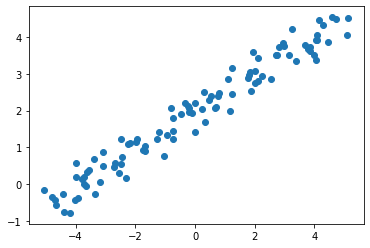

In [201]:
scatter = 0.5
slope = 0.5
intercept = 2
# Uniformly scattered points off a line
train_lin_x = [[-5 + 0.1*i + scatter*(-1+2*random.random())] for i in range(100)]
train_lin_y = [[intercept + slope*(-5+0.1*i) + scatter*(-1+2*random.random())] for i in range(100)]
plt.scatter(train_lin_x, train_lin_y)

In [199]:
# Estimated slope and intercept are present in the weights of the trained network
errs = linear.train(train_lin_x, train_lin_y, delay=1, epochs=100, learning_rate=0.1, verbose=True)

[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.48549349 1.93962381 0.        ]]


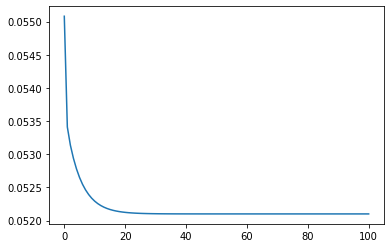

In [200]:
# Seems to work decently well
plt.plot(errs)

In [158]:
rg = GraphNet(10)
for k in range(20):
    i = int(10*random.random())
    j = int(10*random.random())
    rg.connect(i, j)
rg.init_random()
rg.define_input([0])
rg.define_output([9])

In [159]:
rg.stepv([1]) # Making sure the graph's inputs are connected to the outputs -- might want to add a method for that.

2


[0.28853528445530224]

In [164]:
train_x = [[-1+2*random.random()] for i in range(10)]
train_y = [[-1+2*random.random()] for i in range(10)]
errs_rg = rg.train(train_x, train_y, delay=3, epochs=500, learning_rate=0.1, verbose=True)

[[ 0.          0.76604431  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.65658272  0.
   0.          0.          0.          0.        ]
 [ 0.          0.46566976  0.          0.          0.72018871  0.
   0.          0.          0.          0.20448006]
 [ 0.          0.          0.          0.          0.35285997  0.36857224
   0.          0.          0.          0.25964157]
 [ 0.38470388  0.          0.85629552  0.          0.          0.
   0.7162591   0.          0.          0.        ]
 [ 0.89029218  0.          0.          0.          0.30807922  0.
   0.          0.          0.          0.74552709]
 [-0.66182751  0.71031871  0.          0.          0.          0.
   0.          0.34419116  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.   

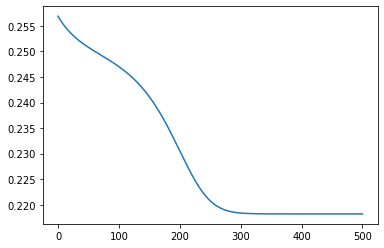

In [165]:
# Oh wow, it actually sort of trained. 
# I wouldn't expect the minimum error to be 0 with random meaningless data, but this at least seems to be decreasing.
plt.plot(errs_rg)

In [179]:
# Testing a regular NN as a graph
xor_net = GraphNet(6)
xor_net.define_input([0,1])
xor_net.connect(0,3)
xor_net.connect(0,4)
xor_net.connect(1,3)
xor_net.connect(1,4)
xor_net.connect(2,3)
xor_net.connect(2,4)
xor_net.connect(2,5)
xor_net.connect(3,5)
xor_net.connect(4,5)
xor_net.activation(2, 'bias')
xor_net.activations([3,4,5], 'sigmoid')
xor_net.init_random()

In [180]:
train_x = [[0,0], [0,1], [1,0], [1,1]]
train_y = [[0], [1], [1], [0]]
errs_xor = xor_net.train(train_x, train_y, delay=2, epochs=10000, learning_rate=0.5, verbose=True)

[[-0.          0.          0.         -0.         -0.          0.        ]
 [ 0.          0.          0.         -0.         -0.          0.        ]
 [ 0.         -0.          0.          0.          0.         -0.        ]
 [-5.32411734  5.09592701 -2.77730006  0.          0.          0.        ]
 [-5.32405609  5.42833254  2.7199878   0.          0.          0.        ]
 [ 0.          0.          3.47485599  7.86496361 -7.48317471  0.        ]]


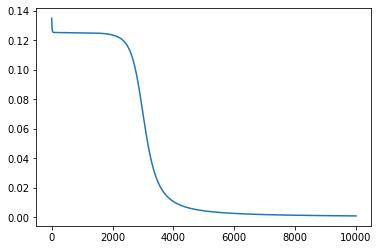

In [181]:
plt.plot(errs_xor)

In [182]:
print(xor_net.stepn([0,0], 2))
print(xor_net.stepn([0,1], 2))
print(xor_net.stepn([1,0], 2))
print(xor_net.stepn([1,1], 2))

[[0.9699638161913268], [0.04372064874053184]]
[[0.9699638161913268], [0.9590727492993009]]
[[0.9699638161913268], [0.9508191804264509]]
[[0.9699638161913268], [0.03849385825652984]]


In [336]:
# Simple recurrent
rec = GraphNet(3)
rec.connect(0,1)
rec.connect(1,1)
rec.activation(1, 'tanh')
rec.connect(1,2)
rec.activation(2, 'sigmoid')
rec.init_random()

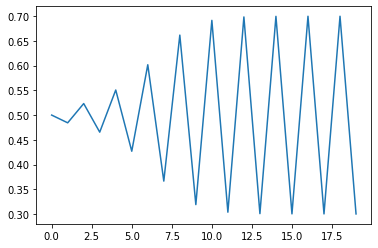

In [342]:
plt.plot(rec.stepn([1], 20))

[[-0.          0.         -0.        ]
 [-0.06339895 -1.49287689 -0.        ]
 [-0.          0.9874735   0.        ]]


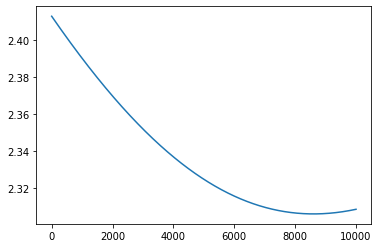

In [341]:
# This clearly still has bugs
plt.plot(rec.train([[[1]]], [[[0.5*(-1)**i] for i in range(12)]], delay=2, learning_rate=0.1, epochs=10000, verbose=True))